In [28]:
import collections

try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

** 멀티라벨 분류 **

비행기, 불상, 나비, 게 4가지의 이미지를 분류해본다

기본적인 방법은 단일 이미지 분류와 같다. 대신, 다중 이미지 분류이기 때문에 카테고리의 변화가 있다.

그리고 단일 보다 데이터셋이 현저히 부족하다. 이는 데이터셋을 잘 못모은 내 잘못이다.

미리 양해를 구한다.


In [29]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./multi_img_data/imgs_others/train"
categories = ["blue", "jumbak", "white","gue","ipgom","america"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.png")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))


blue  파일 길이 :  200
blue  :  ./multi_img_data/imgs_others/train/blue\0000555_SAM_7344.png
jumbak  파일 길이 :  200
jumbak  :  ./multi_img_data/imgs_others/train/jumbak\0001073_09103711.png
white  파일 길이 :  200
white  :  ./multi_img_data/imgs_others/train/white\0003710_09103516.png
gue  파일 길이 :  200
gue  :  ./multi_img_data/imgs_others/train/gue\0016861_20181024_151919.png
ipgom  파일 길이 :  200
ipgom  :  ./multi_img_data/imgs_others/train/ipgom\0005478_20181004_152856.png
america  파일 길이 :  200
america  :  ./multi_img_data/imgs_others/train/america\0013680_SAM_4606_R.png
ok 1200


In [4]:
# import pymssql
# import sys

# if sys.version_info >=(3,3):
#     import collections.abc as collections_abc
# else:
#     import collections as collections_abc

ModuleNotFoundError: No module named 'pymssql'

이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [30]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

(900, 64, 64, 3)
900


In [31]:
categories = ["blue", "jumbak", "white","gue","ipgom","america"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [32]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [34]:

#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 900 samples, validate on 300 samples
Epoch 1/50
900/900 [==============================] - 4s 4ms/step - loss: 1.9043 - accuracy: 0.2356 - val_loss: 1.5150 - val_accuracy: 0.4333

Epoch 00001: val_loss improved from inf to 1.51497, saving model to ./model/multi_img_classification.model
Epoch 2/50
900/900 [==============================] - 4s 4ms/step - loss: 1.1490 - accuracy: 0.4989 - val_loss: 1.0611 - val_accuracy: 0.5200

Epoch 00002: val_loss improved from 1.51497 to 1.06111, saving model to ./model/multi_img_classification.model
Epoch 3/50
900/900 [==============================] - 4s 4ms/step - loss: 0.9278 - accuracy: 0.5922 - val_loss: 0.9273 - val_accuracy: 0.6333

Epoch 00003: val_loss improved from 1.06111 to 0.92731, saving model to ./model/multi_img_classification.model
Epoch 4/50
900/900 [==============================] - 4s 4ms/step - loss: 0.8228 - accuracy: 0.6478 - val_loss: 0.7360 - val_accuracy: 0.7567

Epoch 00004: val_loss improved from 0.92731 to 0.7359

In [65]:
print("정확도 : %.2f" % (model.evaluate(X_test, y_test)[1]*100) +"%%")

300/300 [==============================] - 0s 880us/step
정확도 : 95.00%%


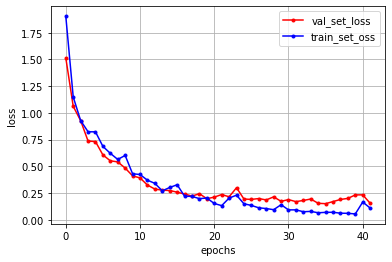

In [36]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [52]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

import pymongo
from pymongo import MongoClient

# client = MongoClient("k4a305.p.ssafy.io:27017")
# db = client.test
# collection = db.diagnosis

client = MongoClient('k4a305.p.ssafy.io', 27017)
db = client['27017']
collection = db.diagnosis

caltech_dir = "./multi_img_data/imgs_others/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
#     "blue", "jumbak", "white","gue","ipgom","america"
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "장미_청벌레병"
    elif pre_ans == 1: pre_ans_str = "장미_점박이응애병"
    elif pre_ans == 2: pre_ans_str = "장미_흰가루병"
    elif pre_ans == 3: pre_ans_str = "토마토_궤양병"
    elif pre_ans == 4: pre_ans_str = "토마토_잎곰팡이병"
    elif pre_ans == 5: pre_ans_str = "토마토_아메리카잎굴파리병"
    if i[0] >= 0.8 : 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로 진단됩니다." % (i[0]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[0]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[0]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[0]*100)}})


        
    if i[1] >= 0.8: 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로 진단됩니다." % (i[1]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[1]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[1]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[1]*100)}})


        
    if i[2] >= 0.8: 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로진단됩니다." % (i[2]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[2]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[2]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[2]*100)}})


        
    if i[3] >= 0.8: 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로 진단됩니다." % (i[3]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[3]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[3]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[3]*100)}})


        
    if i[4] >= 0.8: 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로 진단됩니다." % (i[4]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[3]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[4]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[4]*100)}})

        
    if i[5] >= 0.8: 
        print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"일 확률이 %.2f%%로 진단됩니다." % (i[5]*100))
#         db.diagnosis.update({'pestName': 'pre_ans_str'}, {'percentage' : 'i[5]*100'})
#         db.diagnosis.update({pestName: "pre_ans_str"}, {percentage : "i[5]*100"})
        db.diagnosis.update({'pestName': ''}, {"$set": {'pestName': ""+pre_ans_str, 'percentage' : "%.2f%%"%(i[5]*100)}})


        
        
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


[0.000 0.000 0.000 1.000 0.000 0.000]
3
해당 image0.png이미지는 토마토_궤양병일 확률이 100.00%로 진단됩니다.


C:\Users\multicampus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:81: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


비록 데이터가 적지만 그래도 나름 학습이 잘 되었습니다.

하지만 **validation data와 test data가 나뉘어져 있지 않습니다.**

이는 매우 위험한 시도입니다. 왜냐하면 검증 단계에서 테스트 데이터를 사용했는데 또 마지막에 정확도 검출 시 test_data를 사용합니다.

데이터가 충분하다면 이런짓은 하지 않는게 좋습니다!

하지만 새로운 데이터에 대한 예측은 그래도 잘 하는군요!

In [ ]:
import pymongo
import base64
from pymongo import MongoClient

client = MongoClient("k4a305.p.ssafy.io:27017")
db = client.test
collection = db.diagnosis
    
doc = collection.find({})
    
for i in doc:
    
    print("cropName : " + i["cropName"] + "\r\n" + "img : " + i["img"])
    
    str1 = i["img"] 
    text_base64 = str1
    bytes_base64 = text_base64.encode()
    data = base64.b64decode(bytes_base64)
    test_dir = "multi_img_data/imgs_others/test/"
    open(test_dir+'image.png', 'wb').write(data)
    

#     str1 = i["img"] 
#     from wand.image import Image
#     with Image(filename='inline:data:image/png;base64, '+str1) as img:
#         img.save(filename='result.png')

    
    